In [263]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [264]:
SCALER = 'MINMAX'
LAST_N = -15

In [265]:
df = pd.read_csv('total.csv')
df.head()

,Date,S&P,currency,gold,kospi,kospi_shift
0,2003-12-01,1070.119995,1198.400024,402.700012,807.390015,807.780029
1,2003-12-02,1066.619995,1195.000000,403.700012,807.780029,808.340027
2,2003-12-03,1064.729980,1192.500000,403.899994,808.340027,805.130005
3,2003-12-04,1069.719971,1190.099976,403.299988,805.130005,789.409973
4,2003-12-05,1061.500000,1184.699951,406.399994,789.409973,784.799988


In [266]:
df.tail()

,Date,S&P,currency,gold,kospi,kospi_shift
5320,2024-04-22,5010.600098,1373.930054,2332.199951,2629.439941,2623.020020
5321,2024-04-23,5070.549805,1378.839966,2327.699951,2623.020020,2675.750000
5322,2024-04-24,5071.629883,1370.479980,2324.500000,2675.750000,2628.620117
5323,2024-04-25,5048.419922,1376.969971,2345.600098,2628.620117,2654.820068
5324,2024-04-26,5048.419922,1376.969971,2345.600098,2654.820068,2654.820068


In [267]:
# df = df.drop('Date', axis=1)
df_1 = df.iloc[:LAST_N, :].copy()
df_1 = df_1.drop('Date', axis=1)
print(df_1.tail())
train_x, test_x, train_y, test_y = train_test_split(df_1.loc[:, 'S&P':'kospi'], df_1.loc[:, 'kospi_shift'], train_size=0.9)
col_names = df_1.columns.values
print(col_names)

              S&P     currency         gold        kospi  kospi_shift
5305  5243.770020  1345.310059  2236.500000  2747.860107  2753.159912
5306  5205.810059  1355.530029  2261.000000  2753.159912  2706.969971
5307  5211.490234  1350.729980  2294.399902  2706.969971  2742.000000
5308  5147.209961  1344.839966  2288.800049  2742.000000  2714.209961
5309  5204.339844  1351.359985  2325.699951  2714.209961  2717.649902
['S&P' 'currency' 'gold' 'kospi' 'kospi_shift']


In [268]:
scale_params = pd.DataFrame(index=['mean', 'var', 'max', 'min'])
for i in col_names[:-1]:
    scale_params[i] = [train_x[i].mean(), train_x[i].var(), train_x[i].max(), train_x[i].min()]
scale_params

,S&P,currency,gold,kospi
mean,2.171612e+03,1127.846664,1244.744486,1937.773961
var,1.265336e+06,12198.335056,214436.553412,290728.902187
max,5.254350e+03,1571.400024,2325.699951,3305.209961
min,6.765300e+02,886.679993,374.799988,726.440002


In [269]:
# scaling
train_data = pd.DataFrame()
test_data = pd.DataFrame()
if SCALER == 'MINMAX':
    for i in col_names[:-1]:
        train_data[i] = train_x[i].apply(lambda x: (x - scale_params.loc['min', i])/(scale_params.loc['max', i] - scale_params.loc['min', i]))
        test_data[i] = test_x[i].apply(lambda x: (x - scale_params.loc['min', i])/(scale_params.loc['max', i] - scale_params.loc['min', i]))
elif SCALER == 'NORMAL':
    for i in col_names[:-1]:
        train_data[i] = train_x[i].apply(lambda x: (x - scale_params.loc['mean', i])/scale_params.loc['var', i])
        test_data[i] = test_x[i].apply(lambda x: (x - scale_params.loc['mean', i])/scale_params.loc['var', i])
test_data.tail()

,S&P,currency,gold,kospi
377,0.108038,0.160650,0.026859,0.076370
2614,0.246528,0.249328,0.438516,0.486267
2553,0.219950,0.289637,0.489825,0.495438
1335,0.042319,0.679869,0.228356,0.166866
3768,0.447056,0.279384,0.484904,0.673856


In [270]:
xgb = XGBRegressor()
lgbm = LGBMRegressor()
rf = RandomForestRegressor(random_state = 0, n_jobs = -1)
model_list = [xgb, lgbm, rf]

In [271]:
# XGB
param_xgb = {"max_depth": [10, 30, 50],
              "min_child_weight" : [1, 3, 6, 10],
              "n_estimators": [100, 200, 300, 500, 1000]
              }    
# LGB                        
param_lgbm = {"learning_rate" : [0.01, 0.1, 0.2, 0.5],
             "max_depth" : [25, 50, 75],
             "num_leaves" : [100, 300, 500, 1000],
             "n_estimators" : [100, 200, 300, 500, 1000],
             "learning_rate" : [0.01, 0.1, 0.2, 0.5]
              }
params_rf = { 'n_estimators' : [10, 100],
           'max_depth' : [6, 8, 10, 12],
           'min_samples_leaf' : [8, 12, 18],
           'min_samples_split' : [8, 16, 20]
            }
params_list = [param_xgb, param_lgbm, params_rf]

In [272]:
# grid_result = pd.DataFrame(columns=['xgb', 'lgbm', 'rf'], index=['params', 'best'])

# for i in range(len(model_list)):
#     grid_model = GridSearchCV(estimator=model_list[i], param_grid=params_list[i], scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
#     grid_model.fit(train_x, train_y)
#     # grid_result.iloc[0, i] = grid_model.best_params_
#     # grid_result.iloc[1, i] = grid_model.best_score_
#     print(grid_model.best_params_)
#     print(grid_model.best_score_)

# grid_result

In [273]:
rf = RandomForestRegressor(n_estimators=100, max_depth=12, min_samples_leaf=16, min_samples_split=8, random_state=99)
rf.fit(train_data, train_y)
pred = rf.predict(test_data)

result = mean_squared_error(test_y, pred)
result

526.2138721984828

kospi       0.999826
S&P         0.000067
currency    0.000059
gold        0.000049
dtype: float64


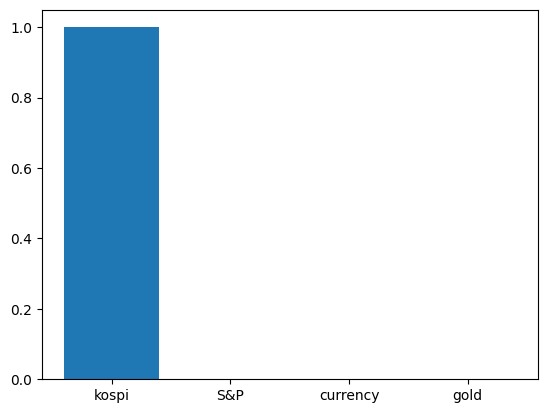

In [274]:
rf_importances = pd.Series(rf.feature_importances_, index = train_x.columns)
plt.bar(rf_importances.sort_values(ascending=False).index, rf_importances.sort_values(ascending=False))
print(rf_importances.sort_values(ascending=False))
plt.show()

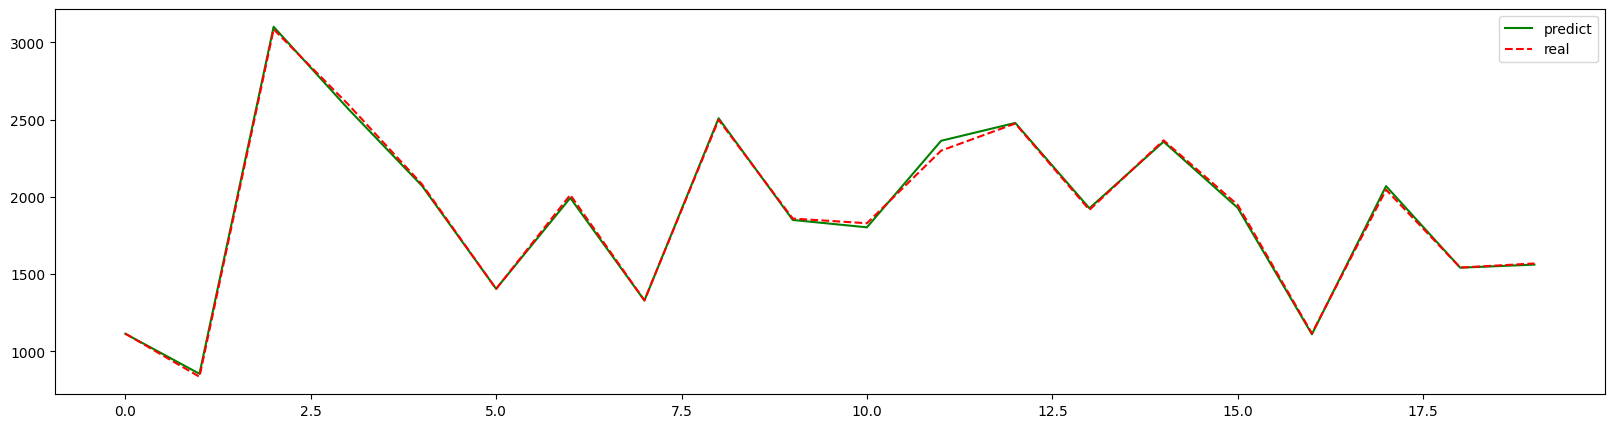

In [275]:
plt.figure(figsize=(20, 5))
plt.plot(pred[-50:-30], 'g-', label='predict')
plt.plot(test_y[-50:-30].values, 'r--', label='real')
plt.legend()
plt.show()

In [276]:
# recent untested data prediction
for i in col_names[:-1]:
    input = df.iloc[LAST_N:, 1:].drop('kospi_shift', axis=1).apply(lambda x: (x - scale_params.loc['min', i])/(scale_params.loc['max', i] - scale_params.loc['min', i]))
pred_last = rf.predict(input)
df_pred = pd.DataFrame(columns=['y', 'pred', 'diff'])
df_pred['pred'] = pred_last
df_pred['y'] = df.iloc[LAST_N:, -1:].values
df_pred['diff'] = df_pred['y'] - df_pred['pred']
df_pred

,y,pred,diff
0,2705.159912,2707.686496,-2.526584
1,2706.959961,2705.840770,1.119191
2,2706.959961,2705.840770,1.119191
3,2681.820068,2706.232910,-24.412842
4,2670.429932,2674.679683,-4.249751
5,2609.629883,2672.572588,-62.942705
6,2584.179932,2614.869121,-30.689190
7,2634.699951,2574.915937,59.784014
8,2591.860107,2633.855217,-41.995110
9,2629.439941,2583.398050,46.041891


In [277]:
df.iloc[LAST_N:, 0:1].values.reshape(-1)

array(['2024-04-08', '2024-04-09', '2024-04-10', '2024-04-11',
       '2024-04-12', '2024-04-15', '2024-04-16', '2024-04-17',
       '2024-04-18', '2024-04-19', '2024-04-22', '2024-04-23',
       '2024-04-24', '2024-04-25', '2024-04-26'], dtype=object)

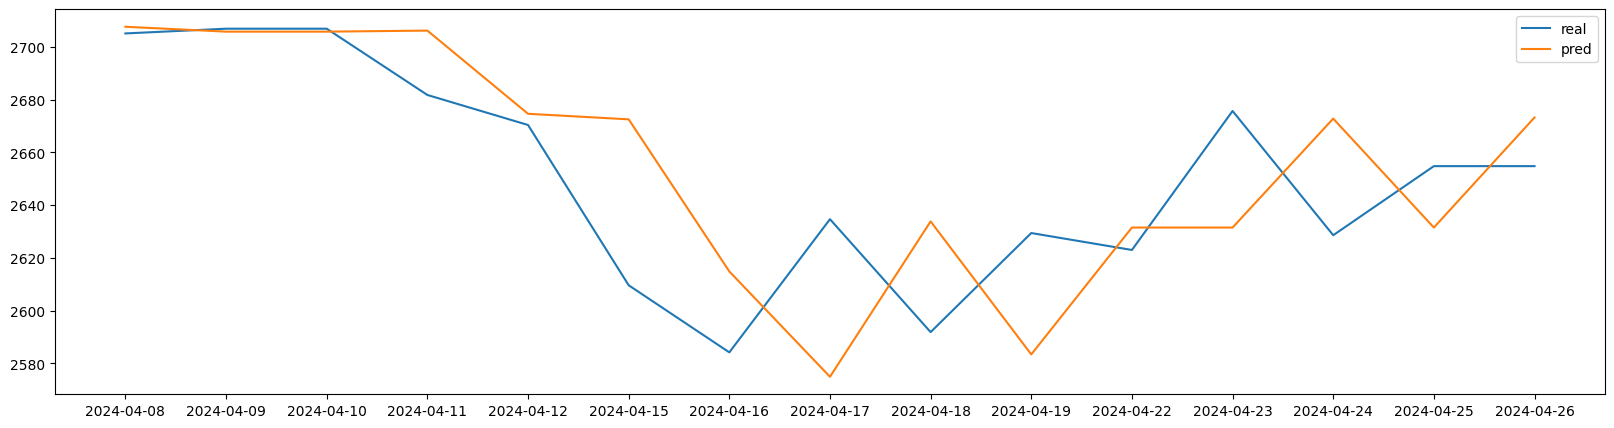

In [278]:
# recent untested data prediction
plt.figure(figsize=(20, 5))
plt.plot(df.iloc[LAST_N:, 0:1].values.reshape(-1), df_pred['y'], label='real')
plt.plot(df.iloc[LAST_N:, 0:1].values.reshape(-1), df_pred['pred'], label='pred')
plt.legend()
plt.show()

In [279]:
df_test_result = pd.merge(test_y, df['Date'], left_index=True, right_index=True, how='left')
df_test_result['pred'] = pred
df_test_result = df_test_result[['Date', 'pred', 'kospi_shift']]
df_test_result['diff'] = df_test_result['pred'] - df_test_result['kospi_shift']
df_test_result = df_test_result.sort_index(ascending=True)
df_test_result

,Date,pred,kospi_shift,diff
1,2003-12-02,806.026027,808.340027,-2.313999
30,2004-01-12,854.123758,848.429993,5.693766
40,2004-01-26,864.925248,863.030029,1.895219
45,2004-02-02,857.044568,839.869995,17.174573
62,2004-02-25,864.377838,864.859985,-0.482147
...,...,...,...,...
5247,2024-01-10,2543.930077,2540.270020,3.660058
5253,2024-01-18,2441.879162,2472.739990,-30.860828
5260,2024-01-29,2508.717054,2498.810059,9.906995
5263,2024-02-01,2543.930077,2615.310059,-71.379981


In [280]:
(np.square(df_test_result['diff']).sum()/len(df_test_result))**0.5

22.939352043998166

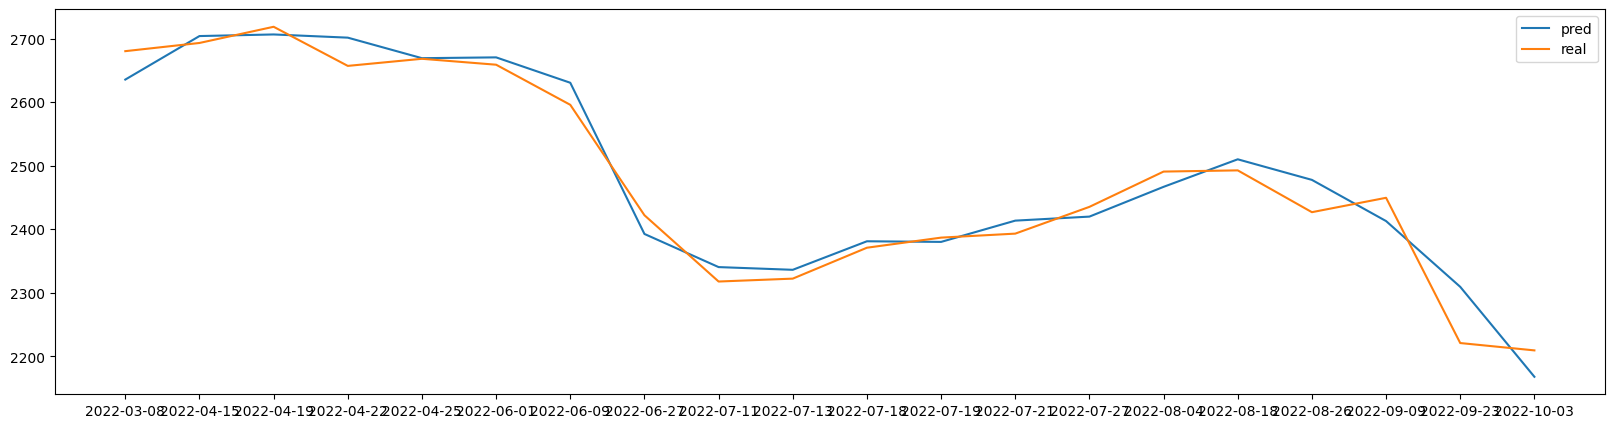

In [281]:
start = -60
end = -40
plt.figure(figsize=(20, 5))
plt.plot(df_test_result.iloc[start:end, 0:1].values.reshape(-1), df_test_result.iloc[start:end, 1:2].values, label='pred')
plt.plot(df_test_result.iloc[start:end, 0:1].values.reshape(-1), df_test_result.iloc[start:end, 2:3].values, label='real')
plt.legend()
plt.show()